# Healy chapter 5 figures (2022-09-02)

_by A. Maurits van der Veen_  

_Modification history:_  
_2022-08-20 - Initial version_  
_2022-09-03 - Clean-up_  

This notebook provides python code to parallel the R code in Healy's Data Visualization book. 

It uses the `plotnine` module in python, which replicates most of ggplot.


## 0. General preparation

The code relies on several python modules, which may need to be installed first. To do so, uncomment the next X code snippets.

- `plotnine` is the main module replicating ggplot
- `mizani` provides axis label formatting
- `pyreadr` reads R-format datasets
- `adjustText` is used to move text around to avoid overlapping (alternative to ggrepel)


In [1]:
# !pip install plotnine


In [2]:
# !pip install mizani


In [3]:
# !pip install pyreadr


In [4]:
# !pip install adjustText


In [5]:
import math
import numpy as np

import pandas as pd
# import geopandas as gpd  # Not necessary until chapter 7

import matplotlib.pyplot as plt

from plotnine import *  # alternative: import plotnine as p9 and always use prefix
from mizani.formatters import currency_format, percent_format

import adjustText

import pyreadr


## Chapter 5 - Graph tables, add labels, make notes


The headings below correspond to chapter sections in the book, with the same titles. Where the title is purely R-specific (as in section 5.1 here), I have added an adjustment in italics.

In [6]:
localfolder = '/Users/yourname/Downloads/'  # Change to local path


In [7]:
# Retrieve & load data from the website associated with Healy's book

remotefolder = 'https://github.com/kjhealy/socviz/blob/master/data/'

datasetname = 'gss_sm'
targetfile = datasetname + '.rda'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
gss_sm = newdata[datasetname]

datasetname = 'organdata'
targetfile = datasetname + '.rda'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
organdata = newdata[datasetname]

datasetname = 'elections_historic'
targetfile = datasetname + '.rda'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
elections_historic = newdata[datasetname]


In [8]:
# in gss_sm, replace Null religion by 'NA': now NA will get plotted, as in the book

religions = ['Protestant', 'Catholic', 'Jewish', 'None', 'Other']

gss_smY = gss_sm.copy()
gss_smY['religion'] = gss_smY.apply(lambda row: 'NA' if row['religion'] not in religions else row['religion'], axis=1)

### 5.1 Use pipes to summarize data _(no pipes in python, use pandas' groupby instead)_

Note: in pandas, we generally use groupby instead.

In [9]:
# Keep only bigregion and religion variables, and get the size of each cell
rel_by_region = gss_smY[['bigregion', 'religion']].groupby(['bigregion', 'religion']).size().reset_index(name='N')

# Get subtotals by region, to prepare for getting proportions
regionsize = dict()
for regionname, regiongroup in rel_by_region.groupby('bigregion'):
    regionsize[regionname] = regiongroup['N'].sum()

# Get proportion, and then multiply and round to get clean percentage values
rel_by_region['freq'] = rel_by_region.apply(lambda row: row['N']/regionsize[row['bigregion']], axis=1)
rel_by_region['pct'] = round(rel_by_region['freq'] * 100, 0).astype(int)


In [10]:
# Compare result against table in Healy (pp. 98-99).
# Note that sorting is again done alphabetically by region and then religion

rel_by_region

,bigregion,religion,N,freq,pct
0,Midwest,Catholic,172,0.247482,25
1,Midwest,Jewish,3,0.004317,0
2,Midwest,NA,5,0.007194,1
3,Midwest,None,157,0.225899,23
4,Midwest,Other,33,0.047482,5
5,Midwest,Protestant,325,0.467626,47
6,Northeast,Catholic,162,0.331967,33
7,Northeast,Jewish,27,0.055328,6
8,Northeast,NA,1,0.002049,0
9,Northeast,None,112,0.229508,23


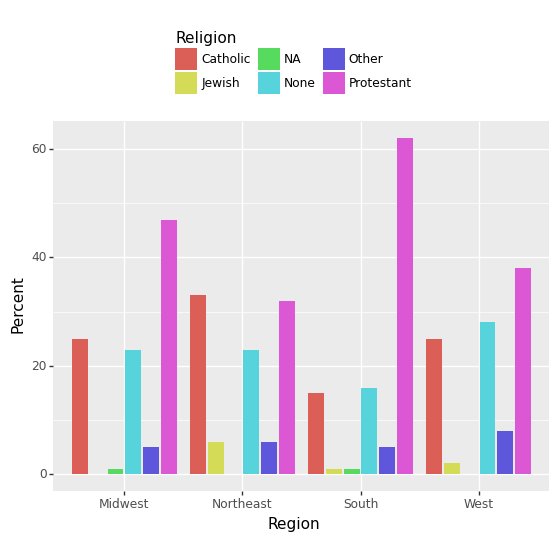

<ggplot: (317463284)>

In [11]:
# Figure 5.2

p = ggplot(rel_by_region, aes(x = 'bigregion', y = 'pct', fill = 'religion'))

p + geom_col(position = 'dodge2') + \
    labs(x = 'Region', y = 'Percent', fill = 'Religion') + \
    theme(legend_position = 'top')

In [12]:
# Set up the data and basic aesthetic, to re-use repeatedly below

p = ggplot(rel_by_region, 
           aes(x = 'religion', y = 'pct', fill = 'religion'))


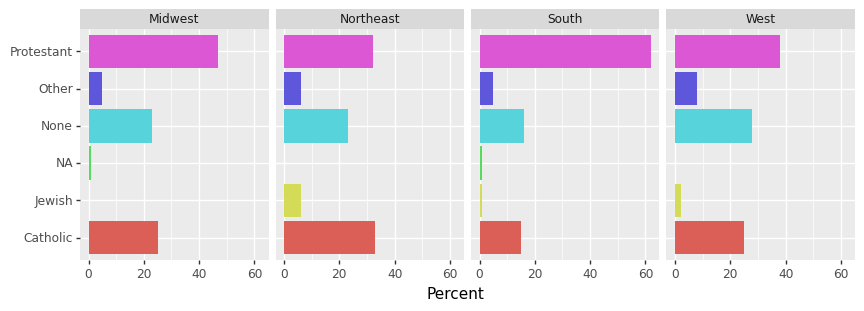

<ggplot: (317602314)>

In [13]:
# Figure 5.3
# Note the use of nrow and of the figure_size option 
# to come closer to replicating the look in the book

# Note also that instead of putting \ after every + to allow us to run across
# multiple lines, we can simply enclose the whole expression in parentheses

(p + geom_col(position = 'dodge2') + 
     labs(x = '', y = 'Percent', fill = 'Religion') + 
     guides(fill = False) + 
     coord_flip() +
     facet_wrap('bigregion', nrow=1) +
     theme(figure_size = (10, 3)))

### 5.2 Continuous variables by group or category

Here we shift to using a new dataset.

In [14]:
# Extract a sample of columns and rows to inspect what the data look like
cols2keep = ['country', 'year', 'donors', 'pop', 'pop_dens', 'gdp']

organdata_sample = organdata[cols2keep].sample(n = 10)
organdata_sample

,country,year,donors,pop,pop_dens,gdp
73,Finland,1993-01-01,19.60,5066,1.498152,17082
202,Switzerland,1996-01-01,12.57,7072,17.127634,26180
14,Austria,None,NaN,7678,9.155736,18914
155,Norway,1991-01-01,15.20,4262,1.315919,19134
191,Sweden,1999-01-01,12.10,8858,1.968619,25099
15,Austria,1991-01-01,27.60,7755,9.247555,19860
6,Australia,1996-01-01,10.59,18311,0.236539,21923
107,Germany,1999-01-01,13.20,82100,22.995267,24100
174,Spain,1996-01-01,26.80,39279,7.762802,16416
205,Switzerland,1999-01-01,14.42,7144,17.302010,28562


/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


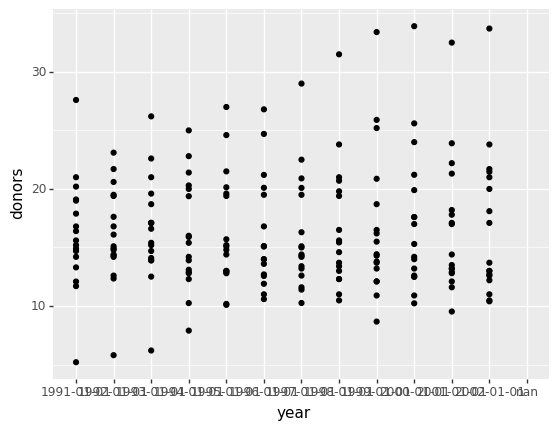

<ggplot: (317467435)>

In [15]:
# Figure 5.4

p = ggplot(data = organdata, 
           mapping = aes(x = 'year', y = 'donors'))

(p + geom_point())

/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


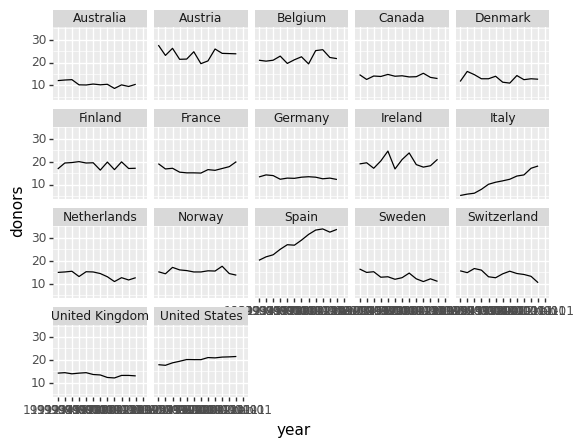

<ggplot: (317763473)>

In [16]:
# Figure 5.5

p + geom_line(aes(group = 'country')) + \
    facet_wrap('country')

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 34 rows containing non-finite values.


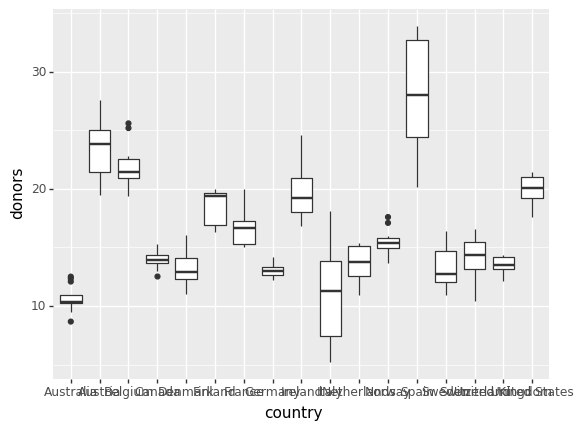

<ggplot: (317716712)>

In [17]:
# Figure 5.6 -- Note that x labels are not automatically made diagonal and thus overlap

p = ggplot(data = organdata, 
           mapping = aes(x = 'country', y = 'donors'))

p + geom_boxplot()

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 34 rows containing non-finite values.


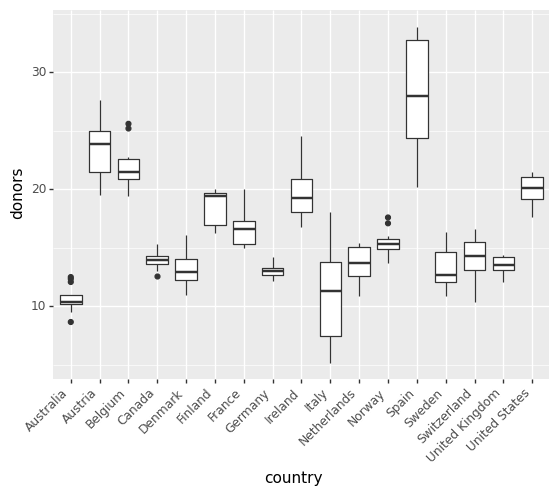

<ggplot: (317762452)>

In [18]:
# Figure 5.6 again, now using a theme option
# to make country names display diagonally

p + geom_boxplot() +\
    theme(axis_text_x = element_text(rotation=45, hjust=1))

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 34 rows containing non-finite values.


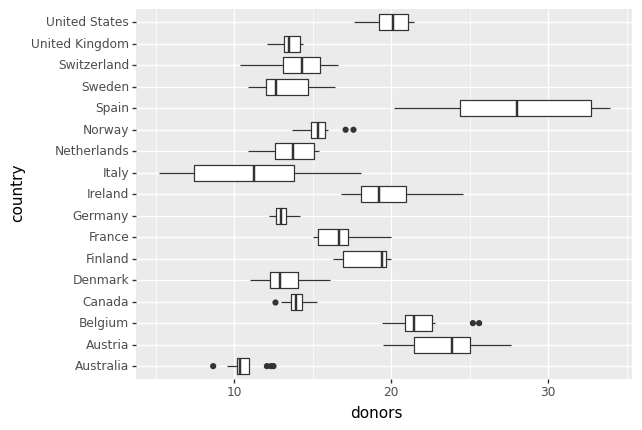

<ggplot: (317557667)>

In [19]:
# Figure 5.7

p + geom_boxplot() + coord_flip()

In [20]:
# In preparation for figure 5.8, sort countries by mean number of donors 
# (averaged across years)

# In ggplot it is possible to do this on the fly
# Note: plotnine has aes(x='reorder(var2, value)' option, usable when
# we have a simple 'sort x by value of y' setup (not here, since we use averages)

meandonors = []
for countryname, countrydata in organdata.groupby('country'):
    meandonors.append((countrydata['donors'].mean(), countryname))
    
countrylist = [country for _, country in sorted(meandonors)]
country_cat = pd.Categorical(organdata['country'], categories=countrylist)

# assign to a new column in the DataFrame
organdata = organdata.assign(country_cat = country_cat)


/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 34 rows containing non-finite values.


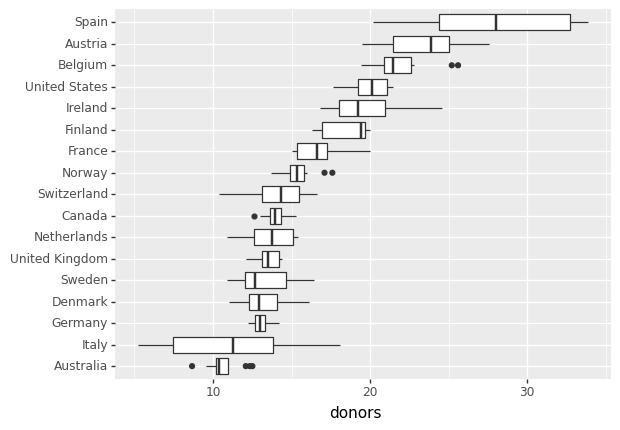

<ggplot: (318446068)>

In [21]:
# Figure 5.8 

p = ggplot(data = organdata, 
           mapping = aes(x = 'country_cat', y = 'donors'))

p + geom_boxplot() +\
    labs(x = '') +\
    coord_flip()

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 34 rows containing non-finite values.


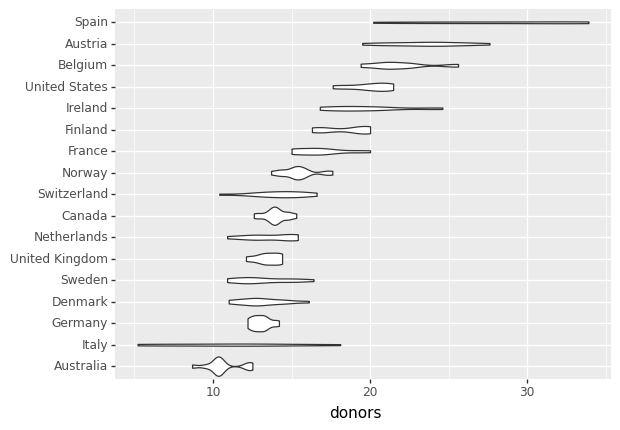

<ggplot: (318539517)>

In [22]:
# Figure 5.8 redone with geom_violin, as suggested in the text

p + geom_violin() +\
    labs(x = '') +\
    coord_flip()

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 34 rows containing non-finite values.


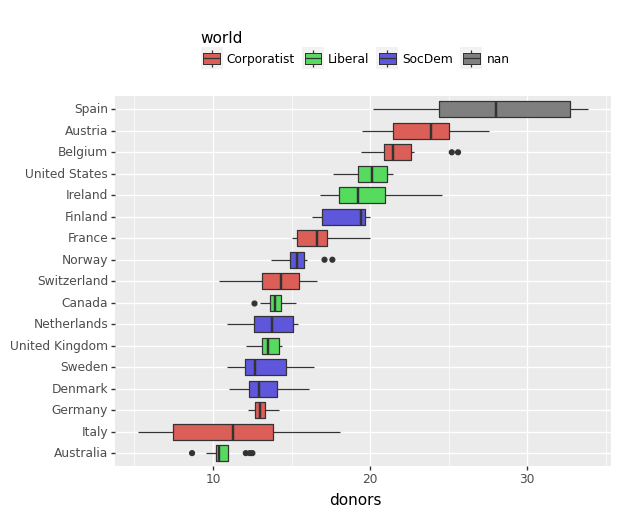

<ggplot: (318608906)>

In [23]:
# Figure 5.9

p = ggplot(data = organdata, 
           mapping = aes(x = 'country_cat', y = 'donors', fill='world'))

p + geom_boxplot() + \
    labs(x = '') + \
    coord_flip() + \
    theme(legend_position = 'top')

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


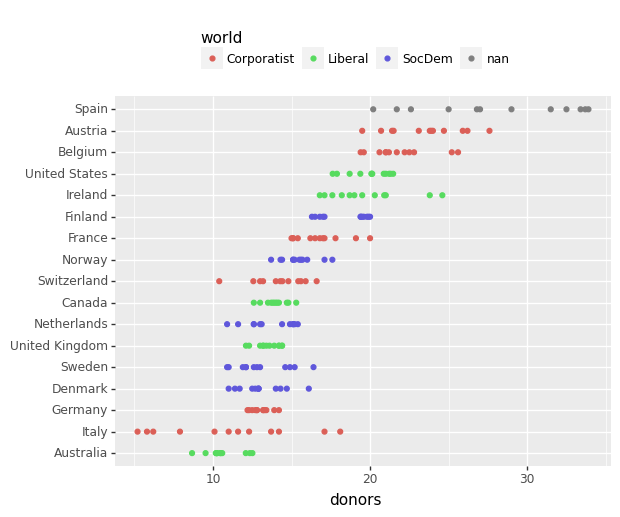

<ggplot: (318604593)>

In [24]:
# Figure 5.10

p = ggplot(data = organdata, mapping = aes(x = 'country_cat', 
                                           y = 'donors', 
                                           color = 'world'))

(p + geom_point() + 
     labs(x = '') + 
     coord_flip() + 
     theme(legend_position = 'top'))

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_jitter : Removed 34 rows containing missing values.


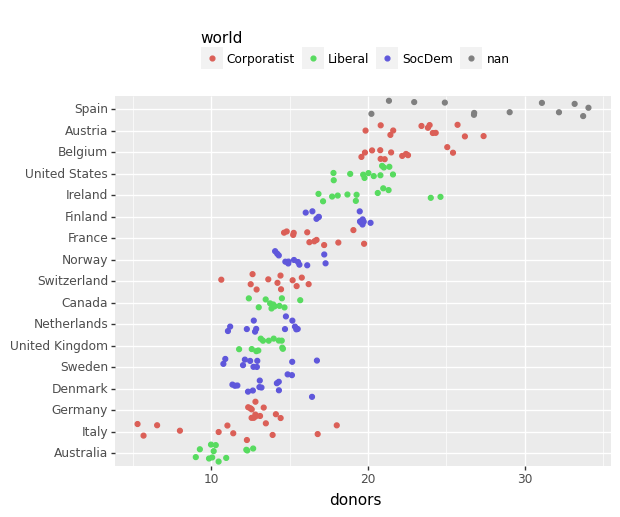

<ggplot: (318607342)>

In [25]:
# Figure 5.11

(p + geom_jitter() + 
     labs(x = '') + 
     coord_flip() + 
     theme(legend_position = 'top'))

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_jitter : Removed 34 rows containing missing values.


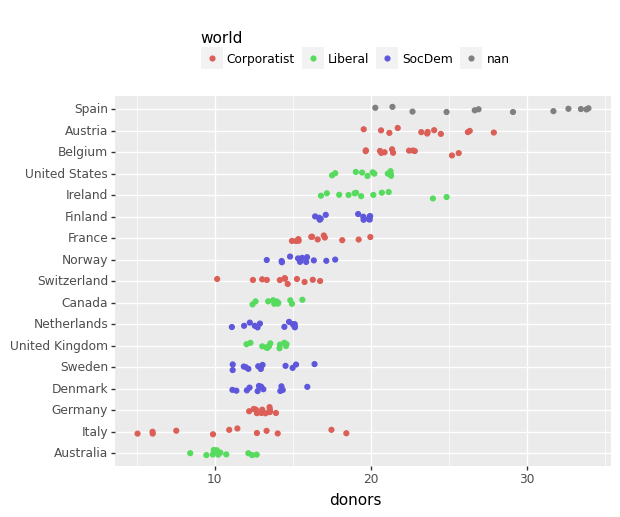

<ggplot: (318602403)>

In [26]:
# Figure 5.12

p + geom_jitter(position = position_jitter(width=0.15)) + \
    labs(x = '') + \
    coord_flip() + \
    theme(legend_position = 'top')

In [27]:
# Check column names of the organdata dataframe
organdata.columns

Index(['country', 'year', 'donors', 'pop', 'pop_dens', 'gdp', 'gdp_lag',
       'health', 'health_lag', 'pubhealth', 'roads', 'cerebvas', 'assault',
       'external', 'txp_pop', 'world', 'opt', 'consent_law',
       'consent_practice', 'consistent', 'ccode', 'country_cat'],
      dtype='object')

In [28]:
# Generate a dataframe with country-level summaries
# In the book, this is done on p. 110, using a pipeline
# Here, we use pandas' groupby
groupcols = ['consent_law', 'country']

# Get means and standard deviations for variables of interest.
# Note: For some reason 'gdp' and 'cerebvas' get dropped if we do it all once!
# This should not happen, but is easy enough to work around by doing them separately
cols2keep = ['donors', 'health', 'roads']  
organdata_grouped = organdata[groupcols + cols2keep].groupby(groupcols)
organdata_means = organdata_grouped.aggregate(np.mean).reset_index()
organdata_stds = organdata_grouped.aggregate(np.std).reset_index()

cols2keep2 = ['gdp', 'cerebvas']
organdata_grouped2 = organdata[groupcols + cols2keep2].groupby(groupcols)
organdata_means2 = organdata_grouped2.aggregate(np.mean).reset_index()
organdata_stds2 = organdata_grouped2.aggregate(np.std).reset_index()

# Now merge the two sets of variables-of-interest together
organdata_means = organdata_means.merge(organdata_means2, left_on=groupcols,
                                                          right_on=groupcols)
organdata_stds = organdata_stds.merge(organdata_stds2, left_on=groupcols,
                                                          right_on=groupcols)

# Finally, merge the two summary dfs together, adjusting names by adding suffixes
by_country = organdata_means.merge(organdata_stds, left_on=groupcols,
                                          right_on=groupcols, suffixes=('_mean', '_std'))


In [29]:
# Add the sorted donor list again to control ordering
country_cat = pd.Categorical(by_country['country'], categories=countrylist)

# assign to a new column in the DataFrame
by_country = by_country.assign(country_cat = country_cat)


In [30]:
# Display by_country (comparable to table on p. 112)
by_country

,consent_law,country,donors_mean,health_mean,roads_mean,gdp_mean,cerebvas_mean,donors_std,health_std,roads_std,gdp_std,cerebvas_std,country_cat
0,Informed,Australia,10.635000,1957.500000,104.875728,22178.538462,557.692308,1.142808,481.627649,14.327316,3958.505665,82.698634,Australia
1,Informed,Canada,13.966667,2271.928571,109.260105,23711.076923,422.384615,0.751161,420.575149,17.679258,3965.847229,38.465436,Canada
2,Informed,Denmark,13.091667,2054.071429,101.636346,23722.307692,640.692308,1.468121,371.361417,12.421001,3895.685292,46.271634,Denmark
3,Informed,Germany,13.041667,2348.750000,112.788734,22163.230769,706.769231,0.611196,377.227474,25.911094,2501.344177,126.035150,Germany
4,Informed,Ireland,19.791667,1479.928571,117.774245,20824.384615,704.692308,2.478437,565.552618,10.761587,6669.580078,87.203196,Ireland
5,Informed,Netherlands,13.658333,1992.785714,76.093567,23013.153846,584.923077,1.551807,417.062102,9.930020,3769.960938,52.232591,Netherlands
6,Informed,United Kingdom,13.491667,1561.214286,67.929360,21359.307692,707.923077,0.775134,405.067929,10.467402,3929.497368,93.435773,United Kingdom
7,Informed,United States,19.981667,3988.285714,155.167832,29211.769231,444.384615,1.325367,864.931961,8.353810,4571.159958,16.049603,United States
8,Presumed,Austria,23.525000,1875.357143,149.865413,23875.846154,768.846154,2.415904,296.897964,30.281692,3342.889440,119.642416,Austria
9,Presumed,Belgium,21.900000,1958.357143,154.695038,22499.615385,593.846154,1.935787,405.114154,20.556129,3170.583636,55.249202,Belgium


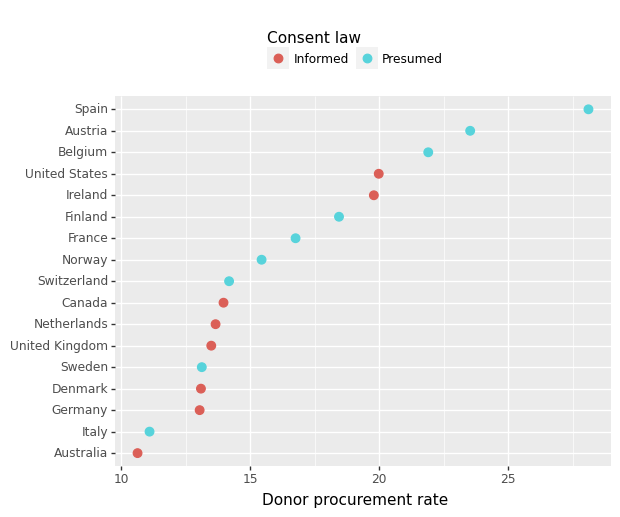

<ggplot: (318696575)>

In [31]:
# Figure 5.13
# Note that in the book the top and bottom dots are on the overall frame of the figure, 
# which is clunky. Plotnine's default is better

p = ggplot(data = by_country,
           mapping = aes(x = 'donors_mean', y = 'country_cat', color='consent_law'))

(p + geom_point(size = 3) +
     labs(x = 'Donor procurement rate',
          y = '',
          color = 'Consent law') +
     theme(legend_position = 'top')
)

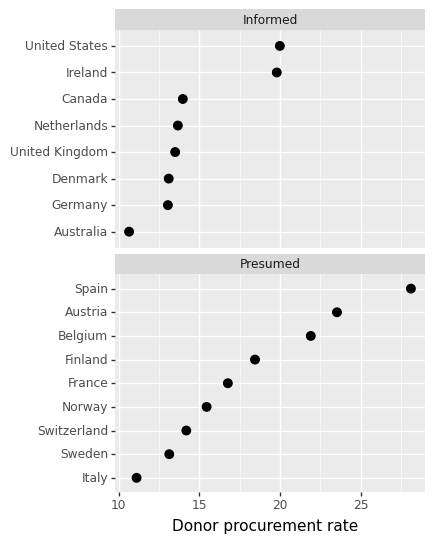

<ggplot: (318012922)>

In [32]:
# Figure 5.14

p = ggplot(data = by_country,
           mapping = aes(x = 'donors_mean', y = 'country_cat'))

(p + geom_point(size = 3) +
     labs(x = 'Donor procurement rate',
          y = '') +
     facet_wrap('consent_law', scales = 'free_y', ncol = 1) +
     theme(figure_size = (4, 6))
)

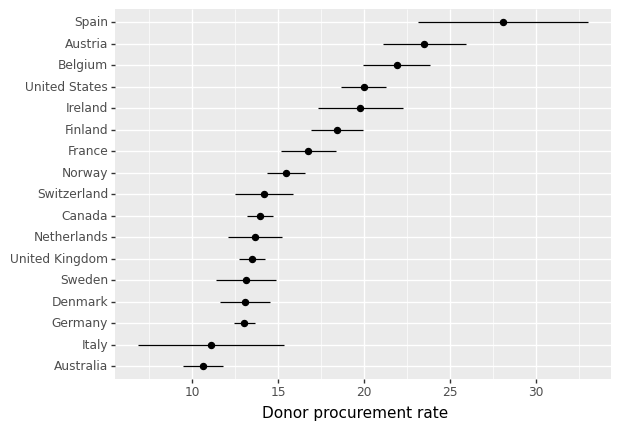

<ggplot: (317467251)>

In [33]:
# Figure 5.15

by_country['donors_low'] = by_country['donors_mean'] - by_country['donors_std']
by_country['donors_high'] = by_country['donors_mean'] + by_country['donors_std']

p = ggplot(data = by_country,
           mapping = aes(x = 'country_cat', y = 'donors_mean'))

(p + geom_pointrange(mapping = aes(ymin = 'donors_low',
                                   ymax = 'donors_high')) +
     labs(x = '',
          y = 'Donor procurement rate') +
     coord_flip()
)

### 5.3 Plot text directly

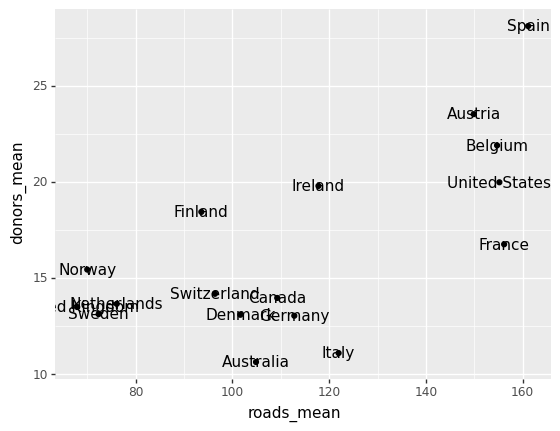

<ggplot: (317741234)>

In [34]:
# Figure 5.16

p = ggplot(data = by_country, mapping = aes(x = 'roads_mean', y = 'donors_mean'))

p + geom_point() + geom_text(mapping = aes(label = 'country'))

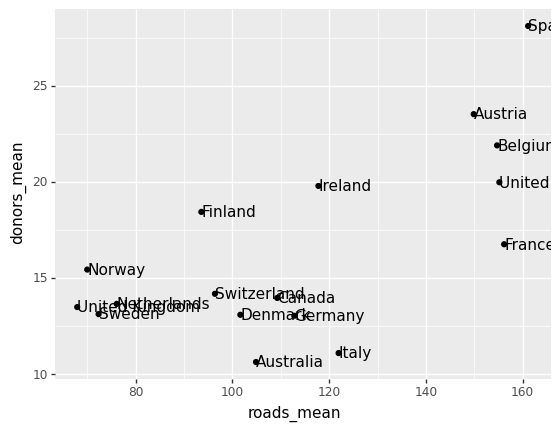

<ggplot: (317775511)>

In [35]:
# Figure 5.17

p + geom_point() + geom_text(mapping = aes(label = 'country'),
                             ha = 'left')

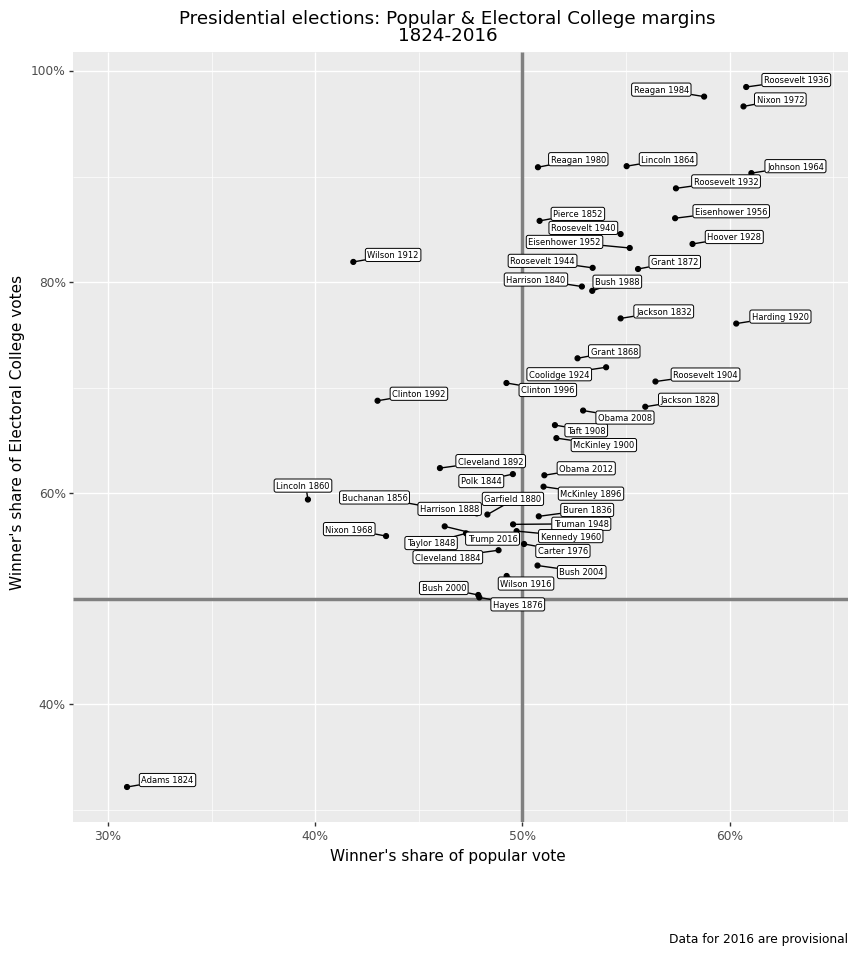

<ggplot: (317855452)>

In [36]:
# Figure 5.18
# Note: instead of using ggrepel, we use the adjust_text option in plotnine,
# which requires the module adjustText (imported at the top)
# Also, we boost the top of the x scale a bit to make sure the text labels don't get cut off
# To avoid unnecessary legend on the right, the show_legend = False is necessary in geom_label

p = ggplot(elections_historic, aes(x = 'popular_pct', y = 'ec_pct'))

# Define some text strings
p_title = 'Presidential elections: Popular & Electoral College margins'
p_subtitle = '1824-2016'
p_caption = 'Data for 2016 are provisional'
x_label = "Winner's share of popular vote"
y_label = "Winner's share of Electoral College votes"

(p + geom_hline(yintercept = 0.5, size = 1.4, color = 'gray') +
     geom_vline(xintercept = 0.5, size = 1.4, color = 'gray') +
     geom_point() +  
     geom_label(aes(label = "winner_label", size = 5),
                adjust_text = {'expand_points': (1.5, 1.5),
                               'arrowprops': {'arrowstyle': '-'}},
                show_legend = False) + 
     scale_x_continuous(limits = (0.30, 0.64), labels = percent_format()) +
     scale_y_continuous(labels = percent_format()) +
     labs(x = x_label, y = y_label,
          title = p_title + '\n' + p_subtitle, caption = p_caption) +
     theme(figure_size = (10, 10))
)

### 5.4 Label outliers

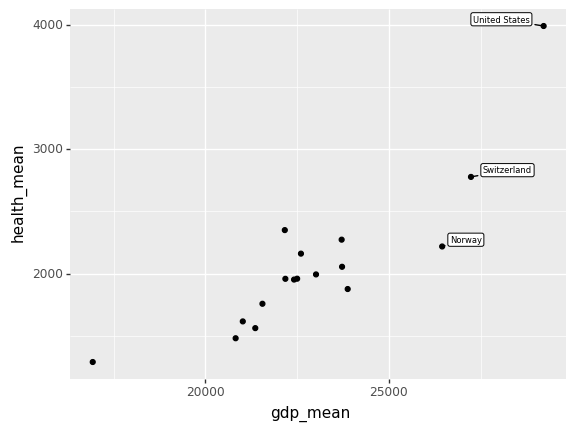

<ggplot: (317814041)>

In [37]:
# Figure 5.19a

p = ggplot(data = by_country,
           mapping = aes(x = 'gdp_mean', y = 'health_mean'))

p + geom_point() + \
    geom_label(data = by_country[by_country['gdp_mean'] > 25000],
               mapping = aes(label = "country", size = 5),
               adjust_text = {'expand_points': (1.5, 1.5),
                           'arrowprops': {'arrowstyle': '-'}},
               show_legend = False)


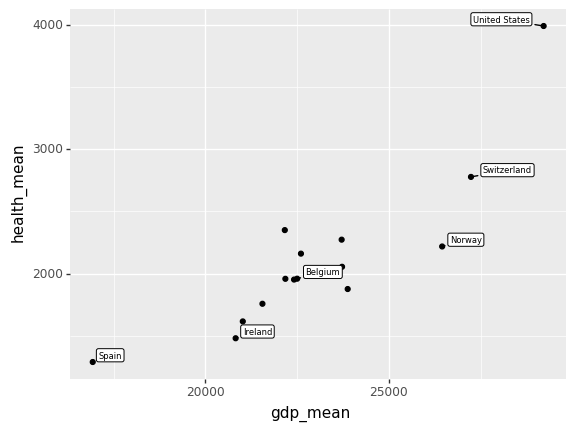

<ggplot: (317838303)>

In [38]:
# Figure 5.19b

p + geom_point() + \
    geom_label(data = by_country[(by_country['gdp_mean'] > 25000) | 
                                 (by_country['health_mean'] < 1500) |
                                 (by_country['country'] == 'Belgium')],
               mapping = aes(label = "country", size = 5),
               adjust_text = {'expand_points': (1.5, 1.5),
                           'arrowprops': {'arrowstyle': '-'}},
               show_legend = False)


In [39]:
# New variable for figure 5.20
# Note: the text says 1998, but to duplicate the graph, we need to use 1988

organdata['ind'] = organdata.apply(lambda row: row['ccode'] in ('Ita', 'Spa') and \
                                               row['year'] is not None and row['year'].year >= 1988, axis = 1)

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


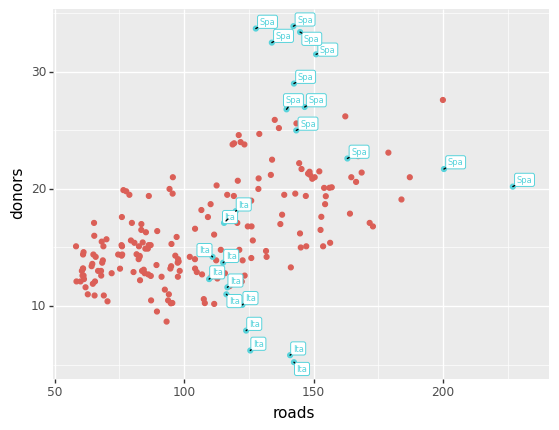

<ggplot: (317607876)>

In [40]:
# Figure 5.20

p = ggplot(data = organdata,
           mapping = aes(x = 'roads', y = 'donors', color = 'ind'))

(p + geom_point() +
     geom_label(data = organdata[organdata['ind']],
                mapping = aes(label = "ccode", size = 5),
                adjust_text = {'expand_points': (1.5, 1.5),
                               'arrowprops': {'arrowstyle': '-'}},
                show_legend = False) +
     guides(color = False)
)

### 5.5 Write and draw in the plot area

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


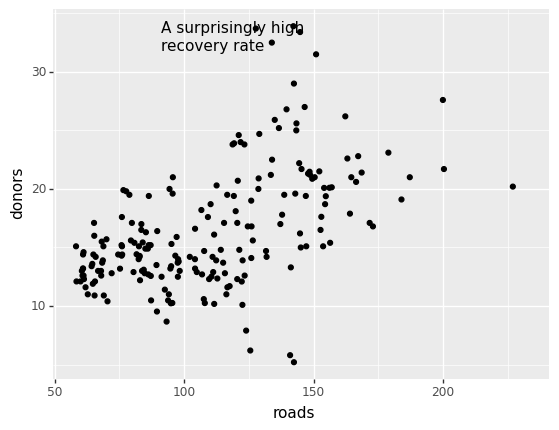

<ggplot: (317927105)>

In [41]:
# Figure 5.21

p = ggplot(data = organdata,
           mapping = aes(x = 'roads', y = 'donors'))

(p + geom_point() +
     annotate(geom = 'text', x = 91, y = 33, 
              label = 'A surprisingly high\nrecovery rate',
              ha = 'left')
)

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


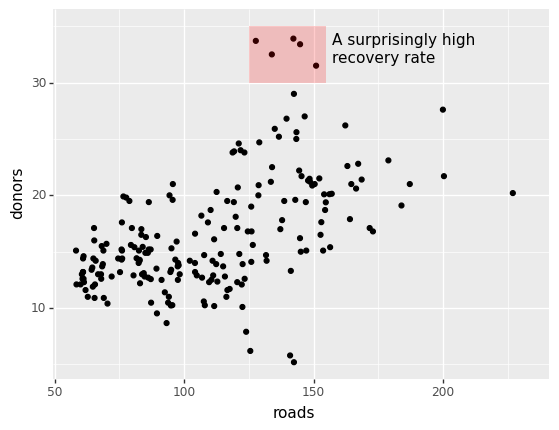

<ggplot: (317888552)>

In [42]:
# Figure 5.22

(p + geom_point() +
     annotate(geom = 'rect', xmin = 125, xmax = 155, ymin = 30, ymax = 35, 
              fill = 'red', alpha = 0.2) +
     annotate(geom = 'text', x = 157, y = 33, 
              label = 'A surprisingly high\nrecovery rate',
              ha = 'left')
)

### 5.6 Understanding scales, guides, and themes

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


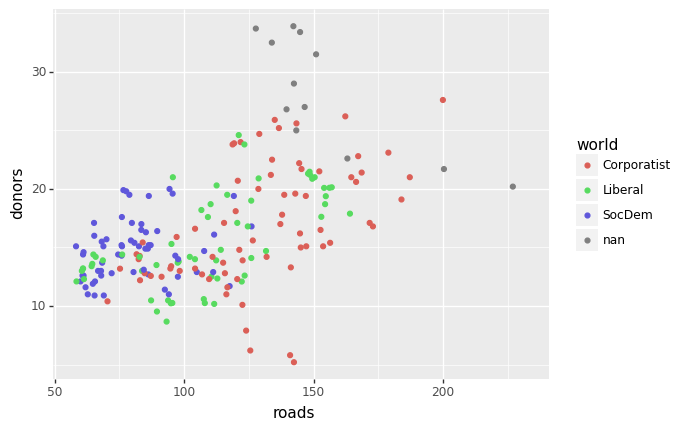

<ggplot: (317921374)>

In [43]:
# Figure 5.23

p = ggplot(data = organdata,
           mapping = aes(x = 'roads',
                         y = 'donors',
                         color = 'world'))

p + geom_point()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


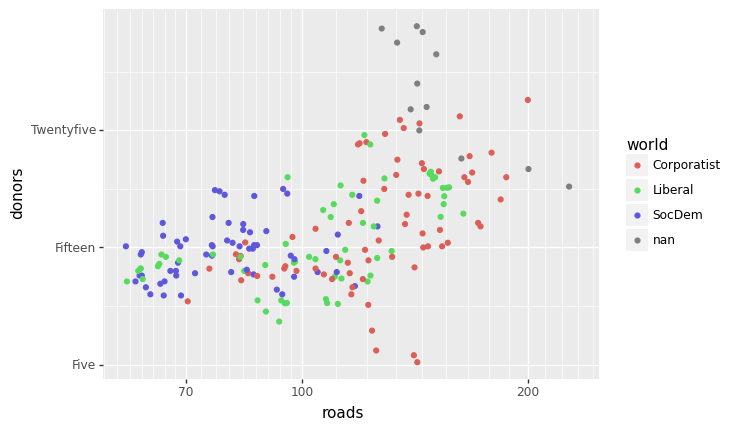

<ggplot: (317854449)>

In [44]:
# Figure 5.25

(p + geom_point() +
     scale_x_log10() + 
     scale_y_continuous(breaks = (5, 15, 25),
                        labels = ('Five', 'Fifteen', 'Twentyfive'))
)

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


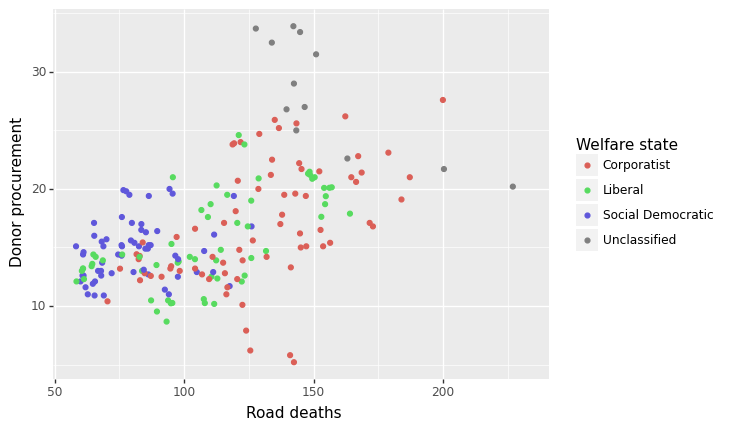

<ggplot: (317809930)>

In [45]:
# Figure 5.26

(p + geom_point() +
     scale_color_discrete(labels = ('Corporatist', 'Liberal', 'Social Democratic', 'Unclassified')) +
     labs(x = 'Road deaths', y = 'Donor procurement', color = 'Welfare state') 
)

/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


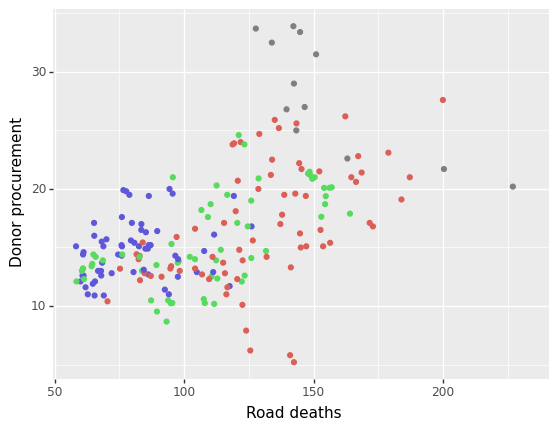

<ggplot: (318205706)>

In [46]:
# Figure 5.27

(p + geom_point() +
     labs(x = 'Road deaths', y = 'Donor procurement') +
     guides(color = False)
)

### This completes the figures for chapter 5